## Bottom Age panan-rOM3 analysis notebook

For `8km_jra_ryf_obc_Charrassin` experiment (MOM6-CICE6 panan 1/12th degree ~ 4km with no ice shelves)

**Note** Several non-standard uses of `esm_datastore`:

- `esm_datastore` was generated with a different branch to main to pick up incorrectly named files (see https://github.com/ACCESS-NRI/access-nri-intake-catalog/issues/459, thanks to Charles Turner for fixing this for me)
- Years 9 and 10 of this run used parallelised IO, and unfortunately the tiling resulted in NaNs along part of the y axis in these files. Therefore, we must use a preprocessing function that replaces these axes with that of an earlier time (month 0) (thanks to Jemma Jeffree for her help with this!)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dask.distributed import Client
import intake
import cmocean as cm

In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38319,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:34627,Total threads: 1
Dashboard: /proxy/33663/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:43299,


2025-08-18 22:14:36,753 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:45261' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('where-d99727742bbe24de3997e81c449a19bc', 6, 3), ('mean_agg-aggregate-nanmax_skip-57d7f07e5b29c475fcb56b06211d97fa', 1, 2, 2)} (stimulus_id='handle-worker-cleanup-1755519276.7534695')
2025-08-18 22:14:36,768 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:38083' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('concatenate-cbca53298b78a4f0b3fd516ec695704d', 105, 3, 2, 1)} (stimulus_id='handle-worker-cleanup-1755519276.7682016')
Task exception was never retrieved
future: <Task finished name='Task-1818330' coro=<Client._gather.<locals>.wait() done, defined at /g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/client.py:2377> exception=AllExit()>
Traceback (most recent call last):
  File "/g/da

Load datastore

In [3]:
esm_datastore = intake.open_esm_datastore(
    "/g/data/ol01/cy8964/access-om3/archive/8km_jra_ryf_obc_Charrassin/experiment_datastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

esm_datastore

,unique
filename,608
file_id,44
path,5088
filename_timestamp,131
frequency,3
start_date,240
end_date,241
variable,201
variable_long_name,183
variable_standard_name,39


List available diagnostics

In [4]:
variables = esm_datastore.unique().variable
print(variables)

['ANGLE', 'ANGLET', 'NCAT', 'VGRDa', 'VGRDb', 'VGRDi', 'VGRDs', 'aice', 'blkmask', 'congel', 'dvidtd', 'dvidtt', 'frazil', 'frzmlt', 'hi', 'hs', 'sifb', 'snoice', 'time', 'time_bounds', 'uvel', 'vvel', 'Tair_m', 'Tsfc_m', 'aice_m', 'aicen_m', 'albice_m', 'albsni_m', 'albsno_m', 'alidf_ai_m', 'alidr_ai_m', 'alvdf_ai_m', 'alvdr_ai_m', 'congel_m', 'daidtd_m', 'daidtt_m', 'divu_m', 'dvidtd_m', 'dvidtt_m', 'evap_ai_m', 'fcondtop_ai_m', 'fcondtopn_ai_m', 'fhocn_ai_m', 'flat_ai_m', 'flatn_ai_m', 'flwdn_m', 'flwup_ai_m', 'fmeltt_ai_m', 'fmelttn_ai_m', 'frazil_m', 'fresh_ai_m', 'frzmlt_m', 'fsalt_ai_m', 'fsalt_m', 'fsens_ai_m', 'fsensn_ai_m', 'fsurfn_ai_m', 'fswabs_ai_m', 'fswdn_m', 'fswthru_ai_m', 'fswup_m', 'hi_m', 'hs_m', 'ice_present_m', 'meltb_m', 'meltl_m', 'melts_m', 'meltt_m', 'opening_m', 'rain_ai_m', 'scale_factor_m', 'shear_m', 'sice_m', 'sifb_m', 'snoice_m', 'snow_ai_m', 'strairx_m', 'strairy_m', 'strcorx_m', 'strcory_m', 'strength_m', 'strintx_m', 'strinty_m', 'strocnx_m', 'strocny

Load month 0 specific datastore to get y axis info

In [5]:
mo0_esm_datastore = intake.open_esm_datastore(
    "/g/data/ol01/cy8964/access-om3/datastores/8km_jra_ryf_obc_Charrassin-output000/experiment_datastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

ds_good_yh = mo0_esm_datastore.search(variable="umo_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
good_yh_coords = ds_good_yh.yh.copy().load()
ds_good_yq = mo0_esm_datastore.search(variable="vmo_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
good_yq_coords = ds_good_yq.yq.copy().load()
def reset_y_coords(ds): #thanks to Jemma Jeffree for helping make this work!!
    ds = ds.assign_coords({'yh':good_yh_coords})
    ds = ds.assign_coords({'yq':good_yq_coords})
    return ds

When loading data that has a y-axis, you need to use the `preprocess` (and likely `decode_timedelta` too) arguments:
```
esm_datastore.search(variable="").to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True})
```

For example:

### Loading other model data from the intake catalogue for comparison

Let's load in the mom6 panan01 and panan005 models, as well as ACCESS-OM2-01-RYF (potentially there is a more suitable one with more diagnostics starting from WOA but it's not on intake?)

In [6]:
catalog = intake.cat.access_nri

In [7]:
catalog.search(model="ACCESS-OM2-01", frequency="1mon",name="01deg_jra55v13_ryf9091")


,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{ocean, seaIce}",{1mon},"{average_T1, pot_rho_2, sss_m, sfc_salt_flux_coupler, ANGLET, total_ocean_river_heat, ty_trans_int_z, tx_trans, alvdr_ai_m, ULON, rhoave, total_ocean_salt, hs_m, total_ocean_hflux_evap, dzt, vicen..."


In [8]:
'''
names of panant models
panant-01-zstar-ACCESSyr2
panant-005-zstar-ACCESSyr2
panant-0025-zstar-ACCESSyr2
'''
catalog.search(name = "panant-01-zstar-ACCESSyr2")


,model,description,realm,frequency,variable
name,,,,,
panant-01-zstar-ACCESSyr2,"{MOM6, SIS2}",{0.1 degree (MOM6+SIS2) Pan-Antarctic regional model configuration under 1990-1991 JRA55-do repeat year forcing.},"{ocean, seaIce}","{1day, 1mon, fx}","{average_T1, Kd_heat, yB, gKEv, hf_dvdt_2d, rho2_l, T_ady, geolat_u, rvxv, tauuo, intz_CAu_2d, geolat, xq, areacello_cv, gKEu, Kd_shear, Kd_interface, dxCv, tauvo, PRCmE, yTe, fsitherm, geolat_c, ..."


# Example: plot mixed layer depth averaged over year 10

In [9]:
# load new panan
panantrom3_age = esm_datastore.search(variable="agessc", frequency = '1mon').to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True}).agessc

# load old panan
panant01_age = catalog["panant-01-zstar-ACCESSyr2"].search(variable="agessc", frequency = '1mon').to_dask(xarray_open_kwargs={'decode_timedelta':True}).agessc
panant005_age = catalog["panant-005-zstar-ACCESSyr2"].search(variable="agessc", frequency = '1mon').to_dask(xarray_open_kwargs={'decode_timedelta':True}).agessc

# load access-om2-01
accessom2_age = catalog["01deg_jra55v13_ryf9091"].search(variable = "age_global",frequency="1mon").to_dask(xarray_open_kwargs={'decode_timedelta':True}).age_global

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. 

In [11]:
accessom2_age
## i.e. access-om2 age was not saved in this dataset before year 50 - need to work out how to load rerun that Will did

<xarray.DataArray 'age_global' (time: 2760, st_ocean: 75, yt_ocean: 2700,
                                xt_ocean: 3600)> Size: 8TB
dask.array<concatenate, shape=(2760, 75, 2700, 3600), dtype=float32, chunksize=(1, 7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 22kB 1950-01-16 12:00:00 ... 2179-12-16 12:00:00
Attributes:
    long_name:      Age (global)
    units:          yr
    valid_range:    [0.e+00 1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_age_since_surface_contact

In [12]:
# define a time slice for the 10th year (panant01 and 005 start at 1991, accessom2 and panantrom3 start at 1900)
time_slice = np.arange(8*12,9*12+12)
time_slice

array([ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119])

In [13]:
# just take year 9 and 10 average (and do a rough .mean() rather than take into account month lengths)
panantrom3_age = panantrom3_age.isel(time = time_slice).mean('time')
panant01_age = panant01_age.isel(time = time_slice).mean('time')
panant005_age = panant005_age.isel(time = time_slice).mean('time')
accessom2_age = accessom2_age.isel(time = time_slice).mean('time')


In [37]:
land_mask.values*1

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 42.73 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 42.14 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/cli

Text(0.5, 0.98, 'Bottom Age, averaged over year 9 and 10')

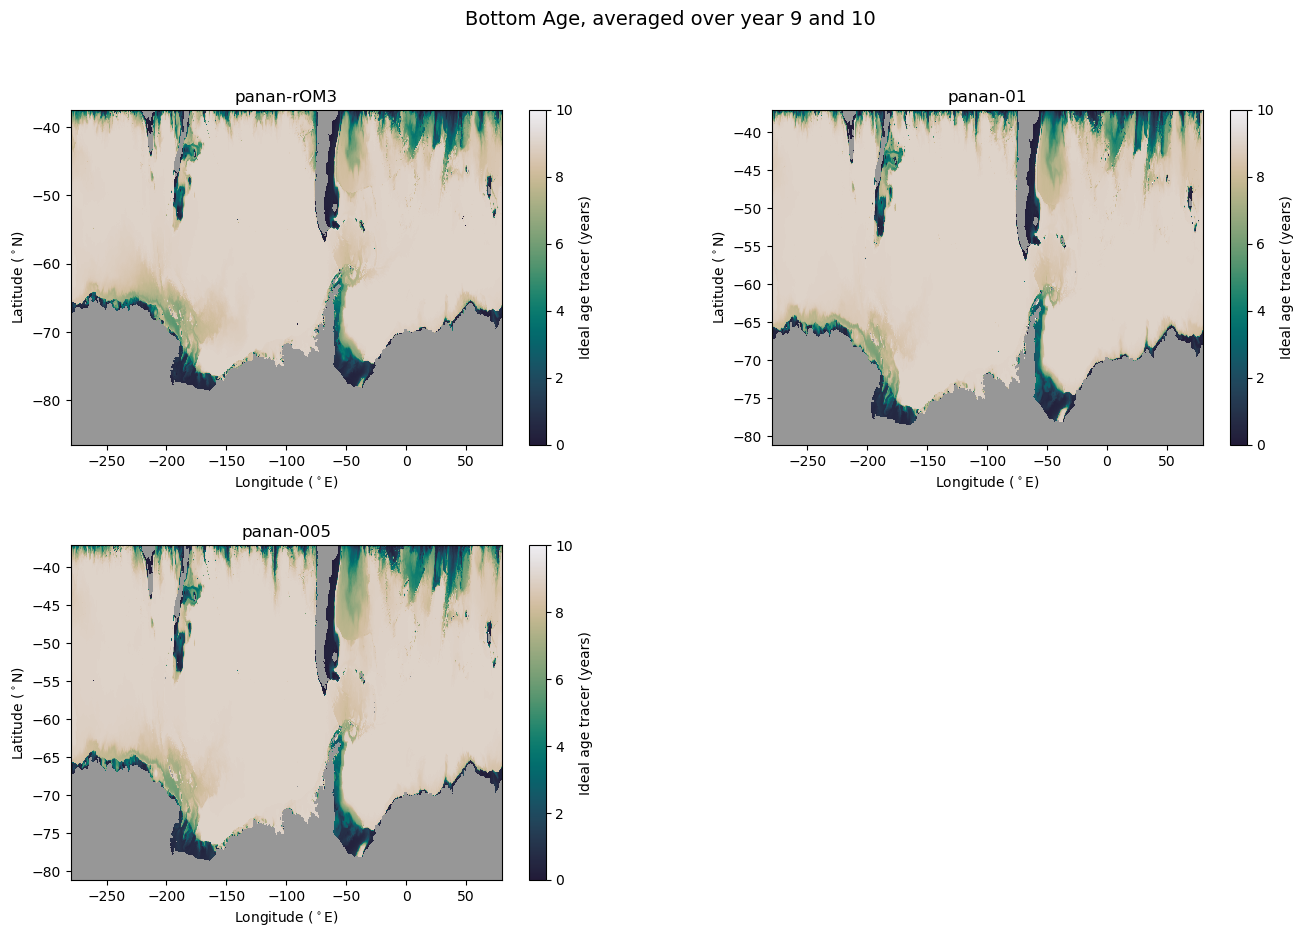

In [45]:
# now plot together

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16,10))
ax = np.ravel(axes)
vmax = 10
vmin = 0
cmap = cm.cm.rain_r

bottom_cell = (panantrom3_age*0+panantrom3_age.z_l).max('z_l')
bottom_age = panantrom3_age.where((panantrom3_age.z_l -0.5) < bottom_cell).where((panantrom3_age.z_l +0.5) > bottom_cell)
age = bottom_age.sum('z_l').load()
age.where(age > 0).plot(ax = ax[0],cmap = cmap, vmax = vmax, vmin = vmin, 
                        cbar_kwargs = {'label':'Ideal age tracer (years)'})
land_mask = xr.ufuncs.isnan(panantrom3_age.isel(z_l = 0))
land_mask = land_mask.where(land_mask > 0)
ax[0].contourf(land_mask.xh, land_mask.yh,land_mask,cmap = 'Greys',vmin = 0, vmax = 2,zorder=2,)
ax[0].set_title('panan-rOM3')

bottom_cell = (panant01_age*0+panant01_age.z_l).max('z_l')
bottom_age = panant01_age.where((panant01_age.z_l -0.5) < bottom_cell).where((panant01_age.z_l +0.5) > bottom_cell)
age = bottom_age.sum('z_l').load()
age.where(age > 0).plot(ax = ax[1],cmap = cmap, vmax = vmax, vmin = vmin, 
                        cbar_kwargs = {'label':'Ideal age tracer (years)'})
land_mask = xr.ufuncs.isnan(panant01_age.isel(z_l = 0))
land_mask = land_mask.where(land_mask > 0)
ax[1].contourf(land_mask.xh, land_mask.yh,land_mask,cmap = 'Greys',vmin = 0, vmax = 2,zorder=2,)
ax[1].set_title('panan-01')

bottom_cell = (panant005_age*0+panant005_age.z_l).max('z_l')
bottom_age = panant005_age.where((panant005_age.z_l -0.5) < bottom_cell).where((panant005_age.z_l +0.5) > bottom_cell)
age = bottom_age.sum('z_l').load()
age.where(age > 0).plot(ax = ax[2],cmap = cmap, vmax = vmax, vmin = vmin, 
                        cbar_kwargs = {'label':'Ideal age tracer (years)'})
land_mask = xr.ufuncs.isnan(panant005_age.isel(z_l = 0))
land_mask = land_mask.where(land_mask > 0)
ax[2].contourf(land_mask.xh, land_mask.yh,land_mask,cmap = 'Greys',vmin = 0, vmax = 2,zorder=2,)
ax[2].set_title('panan-005')

# bottom_cell = (accessom2_age*0+accessom2_age.st_ocean).max('st_ocean')
# bottom_age = accessom2_age.where((accessom2_age.st_ocean -0.5) < bottom_cell).where((accessom2_age.st_ocean +0.5) > bottom_cell)
# age = bottom_age.sum('st_ocean').load()
# age.where(age > 0).sel(yt_ocean = slice(-90,-37)).plot(ax = ax[3],cmap = cmap, vmax = vmax, vmin = vmin, 
#                         cbar_kwargs = {'label':'Ideal age tracer (years)'})
ax[3].set_title('ACCESS-OM2-01')
ax[3].set_visible(False)

for i in np.arange(len(ax)):
    ax[i].set_ylabel('Latitude ($^\circ$N)')
    ax[i].set_xlabel('Longitude ($^\circ$E)')

fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
fig.suptitle('Bottom Age, averaged over year 9 and 10', fontsize = 14)

# test from hackathon 18 Aug - runoff diagnostics

In [10]:
wfo = xr.open_dataset('/home/156/cy8964/mom6-control/access-rom3/8km_jra_ryf_obc2-sapphirerapid-Charrassin-newparams-rerun-Wright-spinup-accessom2IC-yr9/archive/output119/access-om3.mom6.2d.wfo.1mon.mean.1909.nc')
scalr = xr.open_dataset('/home/156/cy8964/mom6-control/access-rom3/8km_jra_ryf_obc2-sapphirerapid-Charrassin-newparams-rerun-Wright-spinup-accessom2IC-yr9/archive/output119/access-om3.mom6.scalar.1day.snap.1909.nc')


/jobfs/147291481.gadi-pbs/ipykernel_875328/502454991.py:1: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  wfo = xr.open_dataset('/home/156/cy8964/mom6-control/access-rom3/8km_jra_ryf_obc2-sapphirerapid-Charrassin-newparams-rerun-Wright-spinup-accessom2IC-yr9/archive/output119/access-om3.mom6.2d.wfo.1mon.mean.1909.nc')


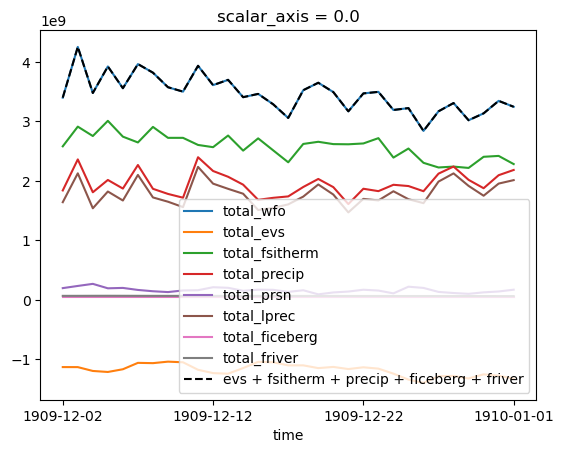

In [17]:
scalr.total_wfo.plot(label = 'total_wfo')
scalr.total_evs.plot(label = 'total_evs')
scalr.total_fsitherm.plot(label = 'total_fsitherm')
scalr.total_precip.plot(label = 'total_precip')
scalr.total_prsn.plot(label = 'total_prsn')
scalr.total_lprec.plot(label = 'total_lprec')
scalr.total_ficeberg.plot(label = 'total_ficeberg')
scalr.total_friver.plot(label = 'total_friver')
(scalr.total_evs+scalr.total_fsitherm+scalr.total_precip+scalr.total_ficeberg+scalr.total_friver).plot(color = 'k',linestyle = '--',label = 'evs + fsitherm + precip + ficeberg + friver')

plt.legend()


In [35]:
!ncdump -h /g/data/ol01/cy8964/mom6/input/input-8km/access-om3-8km-rof-remap-weights_Charrassin_nocavity_cropped.nc

netcdf access-om3-8km-rof-remap-weights_Charrassin_nocavity_cropped {
dimensions:
	n_s = 6229440 ;
variables:
	double S(n_s) ;
		S:_FillValue = NaN ;
	int col(n_s) ;
	int64 row(n_s) ;

// global attributes:
		:gridType = "unstructured mesh" ;
		:inputFile = "/g/data/x77/cy8964/mom6/input/input-8km/access-om3-8km-ESMFmesh_Charrassin_nocavity_cropped.nc (md5 hash: 3e36f72f89f9a61ae4a1ae5a7a1897a9)" ;
		:history = "Created by cy8964 (Claire Yung) on 2025-06-10, using https://github.com/COSIMA/om3-scripts/blob/92cc161e1f19dfa04182d03096591de35f8bbd3d/mesh_generation/generate_rof_weights.py: python3 generate_rof_weights.py --mesh-filename=/g/data/x77/cy8964/mom6/input/input-8km/access-om3-8km-ESMFmesh_Charrassin_nocavity_cropped.nc --weights_filename=/g/data/x77/cy8964/mom6/input/input-8km/access-om3-8km-rof-remap-weights_Charrassin_nocavity_cropped.nc " ;
}


In [29]:
rof_weights = xr.open_dataset('/g/data/ol01/cy8964/mom6/input/input-8km/access-om3-8km-rof-remap-weights_Charrassin_nocavity_cropped.nc')


In [30]:
rof_weights

<xarray.Dataset> Size: 125MB
Dimensions:  (n_s: 6229440)
Dimensions without coordinates: n_s
Data variables:
    S        (n_s) float64 50MB ...
    col      (n_s) int32 25MB ...
    row      (n_s) int64 50MB ...
Attributes:
    gridType:   unstructured mesh
    inputFile:  /g/data/x77/cy8964/mom6/input/input-8km/access-om3-8km-ESMFme...
    history:    Created by cy8964 (Claire Yung) on 2025-06-10, using https://...

In [44]:
rof_weights.col.values

array([      1,       2,       3, ..., 6229438, 6229439, 6229440],
      dtype=int32)

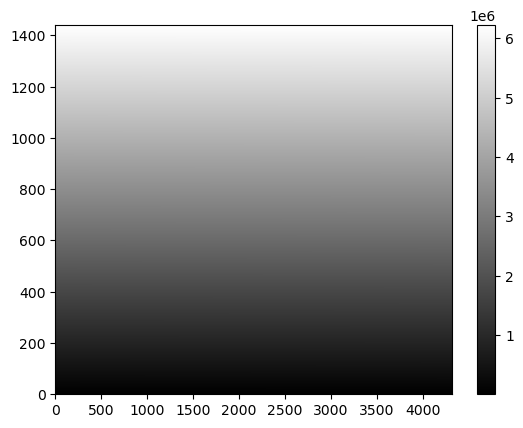

In [39]:
plt.pcolormesh(rof_weights.col.values.reshape(1442,4320), cmap='grey')
plt.colorbar()

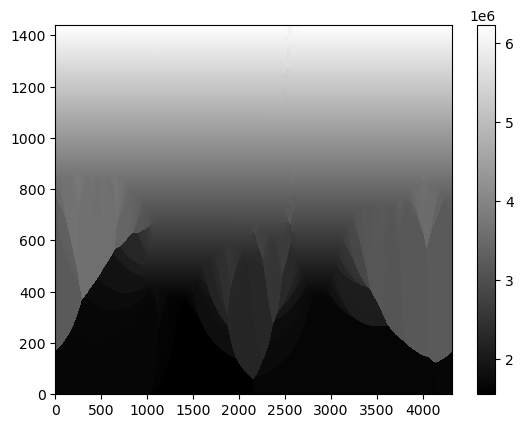

In [40]:
plt.pcolormesh(rof_weights.row.values.reshape(1442,4320), cmap='grey')
plt.colorbar()

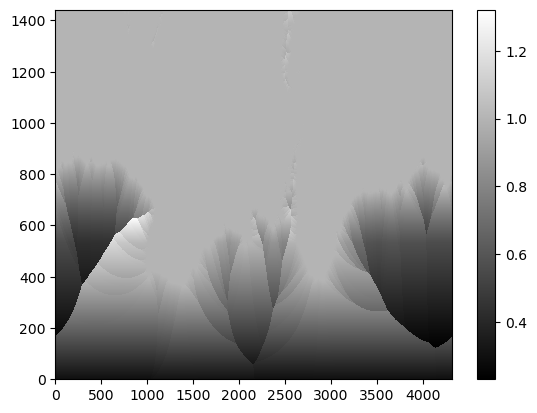

In [43]:
plt.pcolormesh(rof_weights.S.values.reshape(1442,4320), cmap='grey')
plt.colorbar()